In [1]:
import os
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score,balanced_accuracy_score, brier_score_loss, roc_curve, auc, confusion_matrix
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import rpy2
from rpy2.robjects.packages import importr
hmeasure = importr("hmeasure")
output_folder="results"

In [2]:
def plot_roc(ax, actual,predicted,df_label):
    fpr, tpr, thresholds = roc_curve(actual,predicted)
    roc_auc=auc(fpr, tpr)
    lw = 2
    ax.plot(fpr, tpr, lw=lw, label='{} (AUC = {:.2f}%)'.format(df_label,100*roc_auc))
    tp = tpr * sum(actual)
    tn = (1 - fpr) * sum(1-actual)
    accvec = (tp + tn) / len(actual)
    best_threshold = thresholds[np.argmax(accvec)]
    tprfprdiff=tpr-fpr
    return roc_auc, 100*np.amax(accvec), best_threshold, max(tprfprdiff)

In [3]:
def plot_roc_mult(df_list):
    fig=plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=18)
    ax.set_ylabel('True Positive Rate',fontsize=18)
    ax.set_title('Receiver operating characteristic',fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    CM_container=np.zeros((len(df_list),2,2))
    measures_container=pd.DataFrame(dtype=np.float32,index=df_list.keys(),
                                    columns=['Count','Missed','Proportion','Accuracy','Sensitivity','Specificity','Balanced accuracy','AUC','Brier Score','KS','H measure','Max Accuracy','Optimal threshold'])
    for ind, df_key in enumerate(df_list):
        df=df_list[df_key]
        ress = plot_roc(ax, df["actual"], df["scores"],df_key)
        CM_container[ind,:,:]=confusion_matrix(df["actual"], np.round(df["scores"]))
        measures_container['Count'][ind]=len(df["actual"])
        measures_container['Missed'][ind]=sum(df["actual"]==1)
        measures_container['Proportion'][ind]=100*sum(df["actual"]==1)/len(df["actual"])
        measures_container.Accuracy[ind]=100*accuracy_score(df["actual"], df["scores"]>0.5)
        measures_container.Sensitivity[ind]=100*CM_container[ind,1,1]/(CM_container[ind,1,1]+CM_container[ind,1,0])
        measures_container.Specificity[ind]=100*CM_container[ind,0,0]/(CM_container[ind,0,0]+CM_container[ind,0,1])
        measures_container['Balanced accuracy'][ind]=100*balanced_accuracy_score(df["actual"], df["scores"]>0.5)
        measures_container.AUC[ind]=100*ress[0]
        measures_container['Brier Score'][ind]=100*brier_score_loss(df["actual"], df["scores"])
        measures_container['KS'][ind]=ress[3]
        measures_container['Max Accuracy'][ind]=ress[1]
        measures_container['Optimal threshold'][ind]=ress[2]
        Rscores = rpy2.robjects.FloatVector(df["scores"])
        Ractual = rpy2.robjects.IntVector(df["actual"])    
        res = hmeasure.HMeasure(Ractual, Rscores).rx('metrics')
        measures_container['H measure'][ind]=np.array(res[0].rx('H'))[0, 0]
    ax.legend(loc="lower right",fontsize=14)
    return CM_container, measures_container


In [4]:
def plot_calcur(df_list):
    plt.figure(figsize=[10, 10])
    plt.plot([0, 1], [0, 1], "k:")
    plt.ylabel("Fraction of positives",fontsize=18)
    plt.xlabel("Mean predicted value",fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    for ind, df_key in enumerate(df_list):
        df=df_list[df_key]
        fraction_of_positives, mean_predicted_value=calibration_curve(df["actual"],df["scores"],n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-",label=df_key)
    plt.title("Calibration curve",fontsize=18)
    plt.legend(loc='upper left',fontsize=14);

In [5]:
with open("data/classifiers_results_enhanced.pickle", "rb") as fp:
    df_list = pickle.load(fp)
with open("data/LSTM_results.pickle", "rb") as fp:
    df_list['LSTM'] = pickle.load(fp)
   
    
for ind, df_key in enumerate(df_list):    
    act=np.array(df_list[df_key]['actual'])
    pred=np.array(df_list[df_key]['scores'])
    act=np.reshape(act,(-1,5))
    pred=np.reshape(pred,(-1,5))
    delta=act-pred;
    delta[delta<0]=0;
    delta[delta>1]=1;
    delta=np.round(delta)
    accs=1-np.mean(delta,axis=0)
    print(df_key)
    print(np.std(accs)*100)
    aucs=np.zeros((5,1));
    briers=np.zeros((5,1));
    for i in range(5):
        fpr, tpr, thresholds = roc_curve(act[:,i],pred[:,i])
        aucs[i] = auc(fpr, tpr);
        briers[i] = brier_score_loss(act[:,i], pred[:,i])
    print(np.std(aucs)*100)   
    print(np.std(briers)*100)  

Gradient Boosting
0.4110150037812883
0.5254458652278193
0.2554775568180549
Bagging NN
0.4668333035820524
0.42505974231362953
0.2291058890648262
SVM
0.4602414825091517
1.0355014491133046
0.29402858643114077
Random Forest
0.4679268698798496
0.4746617090811073
0.18486457500940326
Logistic Regression
0.41290300179205447
0.7141716398931696
0.1941672010807694
LSTM
0.4219794623754422
0.5174163683939123
0.2369809097371339


                       Count  Missed  Proportion   Accuracy  Sensitivity  \
Gradient Boosting    30000.0  6636.0   22.120001  82.070000    36.467751   
Bagging NN           30000.0  6636.0   22.120001  81.779999    37.070526   
SVM                  30000.0  6636.0   22.120001  81.463333    28.556358   
Random Forest        30000.0  6636.0   22.120001  80.180000    17.013262   
Logistic Regression  30000.0  6636.0   22.120001  80.879997    22.558771   
LSTM                 30000.0  6636.0   22.120001  82.026665    37.432190   

                     Specificity  Balanced accuracy        AUC  Brier Score  \
Gradient Boosting      95.022255          65.745003  78.029526    13.428569   
Bagging NN             94.478683          65.774605  77.534546    13.579756   
SVM                    96.490326          62.523342  69.571426    14.325365   
Random Forest          98.121040          57.567150  76.543213    14.375084   
Logistic Regression    97.444786          60.001778  71.820526    14.551

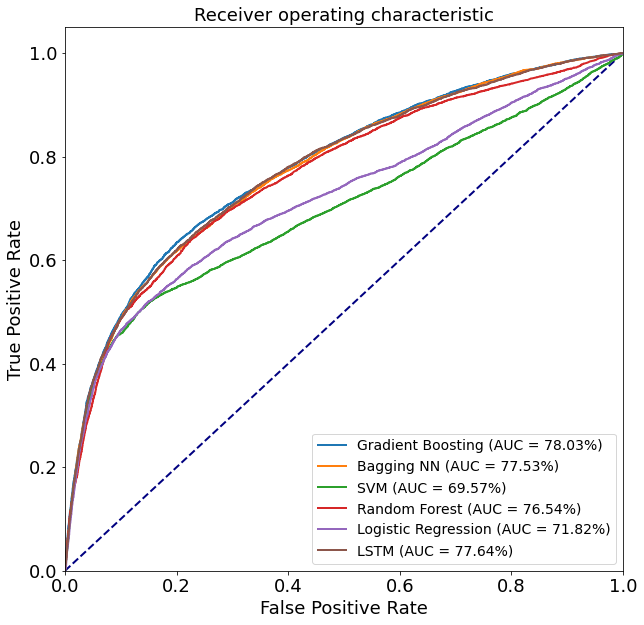

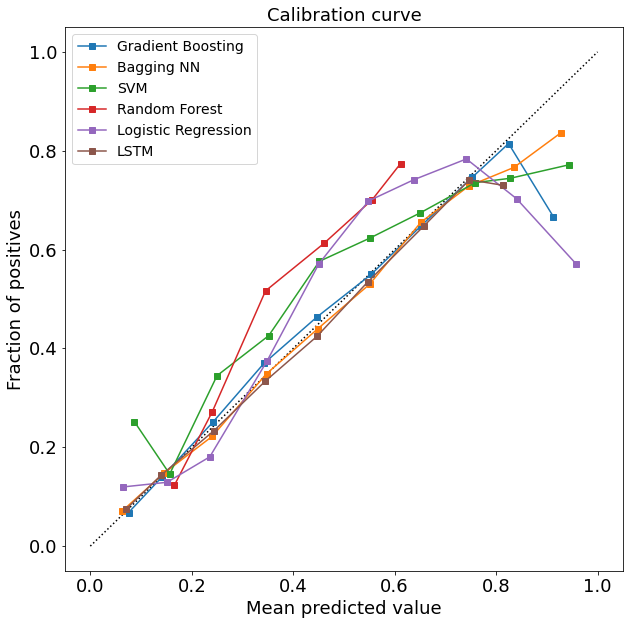

In [6]:
CM_container, measures_container_all=plot_roc_mult(df_list)
plt.savefig(os.path.join(output_folder,"AUC_all_classifiers.jpg"))
print(measures_container_all)
plot_calcur(df_list)
plt.savefig(os.path.join(output_folder,"Calibration_curve_all_classifiers.jpg"))
print(CM_container)

                                     Count  Missed  Proportion   Accuracy  \
All customers                      30000.0  6636.0   22.120001  82.026665   
Missed payment in last 2 months    15265.0  3997.0   26.184082  79.266296   
Missed payment in last month       13714.0  3567.0   26.009916  79.502701   
Two consecutive missed payments     7974.0  2592.0   32.505642  76.812141   
Three consecutive missed payments    313.0   210.0   67.092651  71.884987   

                                   Sensitivity  Specificity  \
All customers                        37.432190    94.692688   
Missed payment in last 2 months      39.879910    93.237488   
Missed payment in last month         39.613121    93.525177   
Two consecutive missed payments      51.311729    89.093277   
Three consecutive missed payments    91.428574    32.038834   

                                   Balanced accuracy        AUC  Brier Score  \
All customers                              66.062439  77.636513    13.529372  

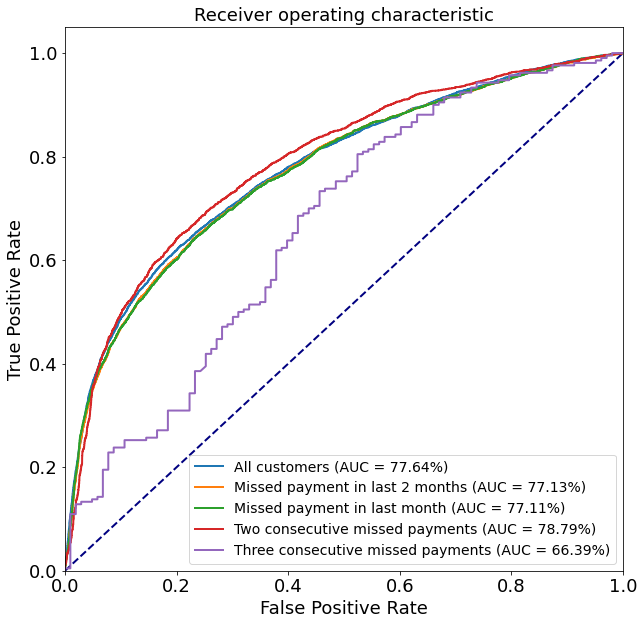

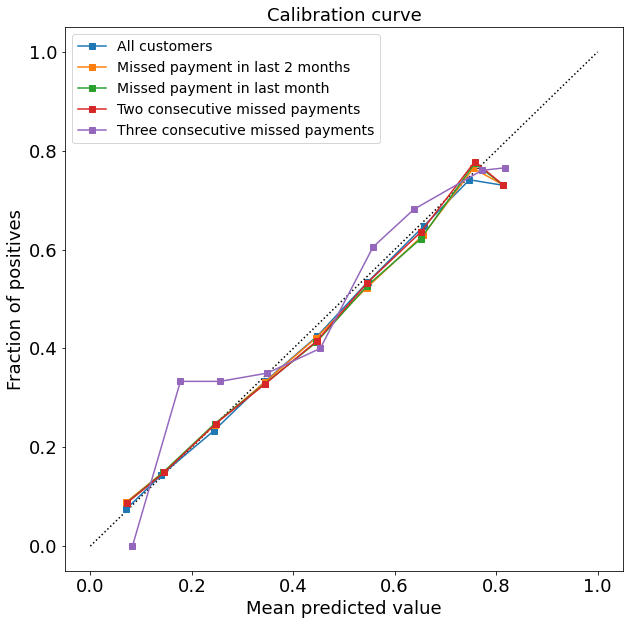

In [7]:
df=pd.read_csv('data/UCI_Credit_Card.csv')
df=df.abs()
res=df_list['LSTM']
g_list={"All customers":res}
g_list['Missed payment in last 2 months']=res[(df.PAY_6>0) | (df.PAY_5>0)]
g_list['Missed payment in last month']=res[(df.PAY_6>0)]
g_list['Two consecutive missed payments']=res[(df.PAY_6>1)]
g_list['Three consecutive missed payments']=res[(df.PAY_6>=3)]

CM_container, measures_container=plot_roc_mult(g_list)
plt.savefig(os.path.join(output_folder,"AUC_different_groups_of_customers.jpg"))
plot_calcur(g_list)
plt.savefig(os.path.join(output_folder,"Calibration_curve_different_groups_of_customers.jpg"))
print(measures_container)

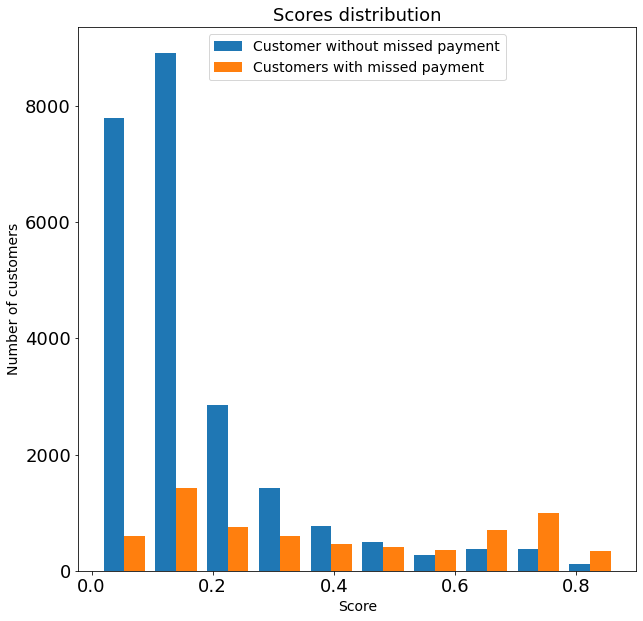

In [8]:
plt.figure(figsize=[10, 10])
ac0=res["scores"][res["actual"]==0]
ac1=res["scores"][res["actual"]==1]
plt.hist([ac0,ac1],label=["Customer without missed payment","Customers with missed payment"]);
plt.title("Scores distribution",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Score",fontsize=14)
plt.ylabel("Number of customers",fontsize=14)
plt.legend(loc='upper center',fontsize=14);
plt.savefig(os.path.join(output_folder,"histogram.jpg"))

In [9]:
with pd.ExcelWriter(os.path.join(output_folder,"enhanced_output.xlsx")) as writer: 
    measures_container.round(2).to_excel(writer, sheet_name='LSTM')
    measures_container_all.round(2).to_excel(writer, sheet_name='All')